In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('combined_data.xlsx')
# Drop the extra index column
df = df.drop(columns=['Unnamed: 0']) 
df

,E (GPa),σu (MPa),σf (MPa),RA (%),εf,HB,σL (MPa)
0,197,783.2,1207.0,55.1,0.800,180,260.0
1,196,905.5,1247.0,41.7,0.540,195,311.7
2,211,821.0,1128.0,49.6,0.700,238,254.5
3,202,828.5,1065.0,34.1,0.416,220,360.2
4,220,2360.0,2115.0,14.7,0.160,536,796.1
...,...,...,...,...,...,...,...
166,205,565.0,931.0,64.0,1.030,159,205.1
167,205,565.0,1000.0,69.0,1.190,150,196.6
168,205,440.0,752.0,65.0,1.060,150,210.5
169,205,530.0,1000.0,72.0,1.240,156,235.5


## Analyzing the dataset

### 1. Checking for any missing value

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   E (GPa)   171 non-null    int64  
 1   σu (MPa)  171 non-null    float64
 2   σf (MPa)  171 non-null    float64
 3   RA (%)    171 non-null    float64
 4   εf        171 non-null    float64
 5   HB        171 non-null    int64  
 6   σL (MPa)  171 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 9.5 KB


### 2. Finding the correlation between target and features

In [4]:
# Separate features and target
features = df.drop(columns=["σL (MPa)"])  # Features
target = df["σL (MPa)"]  # Target

In [5]:
# Correlation analysis
correlation = features.corrwith(target)
print("Correlation with σL (MPa):\n", correlation)

Correlation with σL (MPa):
 E (GPa)    -0.184114
σu (MPa)    0.917524
σf (MPa)    0.789047
RA (%)     -0.392341
εf         -0.432181
HB          0.931089
dtype: float64


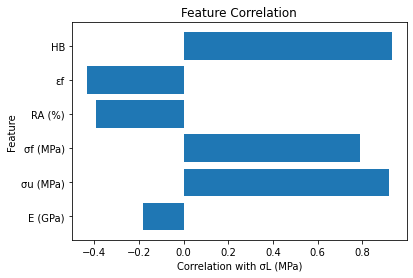

In [6]:
# Plot correlation
plt.barh(features.columns, correlation)
plt.xlabel("Correlation with σL (MPa)")
plt.ylabel("Feature")
plt.title("Feature Correlation")
plt.show()

### HB , RA  for model-2

### Creating the variation for each of the input parameters

In [7]:
# Removing the unecessary features
df = df.drop(columns = ['E (GPa)' , 'σu (MPa)', 'σf (MPa)', 'εf'])
df

,RA (%),HB,σL (MPa)
0,55.1,180,260.0
1,41.7,195,311.7
2,49.6,238,254.5
3,34.1,220,360.2
4,14.7,536,796.1
...,...,...,...
166,64.0,159,205.1
167,69.0,150,196.6
168,65.0,150,210.5
169,72.0,156,235.5


In [8]:
# Adding relevant variations of the features
# for HB
df['exp_hb'] = df['HB'].apply(lambda x: np.exp(0.0036 * x))
df['log_hb'] = df['HB'].apply(lambda x: np.log(x))


# for RA
df['exp_ra'] = df['RA (%)'].apply(lambda x: np.exp(-0.013 * x))
df['log_ra'] = df['RA (%)'].apply(lambda x: np.log(x))
df['square_ra'] = df['RA (%)'].apply(lambda x: x ** 2)


# Reordering dataframe
df = df[['HB','log_hb','exp_hb','RA (%)', 'log_ra', 'exp_ra' , 'square_ra' , 'σL (MPa)']]


In [9]:
df

,HB,log_hb,exp_hb,RA (%),log_ra,exp_ra,square_ra,σL (MPa)
0,180,5.192957,1.911714,55.1,4.009150,0.488557,3036.01,260.0
1,195,5.273000,2.017784,41.7,3.730501,0.581526,1738.89,311.7
2,238,5.472271,2.355611,49.6,3.903991,0.524767,2460.16,254.5
3,220,5.393628,2.207808,34.1,3.529297,0.641915,1162.81,360.2
4,536,6.284134,6.886755,14.7,2.687847,0.826050,216.09,796.1
...,...,...,...,...,...,...,...,...
166,159,5.068904,1.772516,64.0,4.158883,0.435178,4096.00,205.1
167,150,5.010635,1.716007,69.0,4.234107,0.407791,4761.00,196.6
168,150,5.010635,1.716007,65.0,4.174387,0.429557,4225.00,210.5
169,156,5.049856,1.753476,72.0,4.276666,0.392193,5184.00,235.5


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Define your input parameters and their variations
params = {
    'x1': ['HB', 'log_hb', 'exp_hb'],
    'x2': ['RA (%)', 'log_ra', 'exp_ra'],
    
}

#Results dictionary
results = {}

best_accuracy = 0
best_combination = None

# Generate all possible combinations of parameter variations
for x1_variation in params['x1']:
    for x2_variation in params['x2']:
        combination = x1_variation + " , " + x2_variation + 'square_ra'
        print(combination)
        # Prepare dataset with the current combination
        X = df[[x1_variation , x2_variation , 'square_ra']]
        y = df["σL (MPa)"]

        #Test-train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Creating a basic neural network model
        model = Sequential([
        Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(7, activation='relu'),
        Dense(4, activation='relu'),
        #     Dense(10, activation='relu'),
        #     Dense(10, activation='relu'),
        Dense(1)  # Output layer
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        # Train the model with early stopping
        history = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=8, validation_split=0.2, callbacks=[early_stopping], verbose=1)
        # Predict on test set
        y_pred = model.predict(X_test_scaled)

        # Calculate and print accuracy
        accuracy = (1 - mean_squared_error(y_test, y_pred) / np.var(y_test)) * 100
        print("Accuracy:", accuracy)

        #Putting the results in the dictionary
        results[combination] = accuracy


        # Check if current combination gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_combination = (x1_variation, x2_variation, 'square_ra')

# Print the best combination and its accuracy
print("Best Combination:", best_combination)
print("Best Accuracy:", best_accuracy)

HB , RA (%)square_ra
Epoch 1/1000
14/14 [==============================] - 0s 10ms/step - loss: 261591.0312 - val_loss: 230524.0312
Epoch 2/1000
14/14 [==============================] - 0s 2ms/step - loss: 261483.9844 - val_loss: 230444.7969
Epoch 3/1000
14/14 [==============================] - 0s 3ms/step - loss: 261403.0938 - val_loss: 230385.9062
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 261342.4688 - val_loss: 230339.7656
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 261279.0781 - val_loss: 230279.4062
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 261198.3281 - val_loss: 230199.3906
Epoch 7/1000
14/14 [==============================] - 0s 4ms/step - loss: 261097.1406 - val_loss: 230094.6406
Epoch 8/1000
14/14 [==============================] - 0s 3ms/step - loss: 260977.9844 - val_loss: 229972.8594
Epoch 9/1000
14/14 [==============================] - 0s 3ms/step - loss: 260844.0781 - val_loss: 

14/14 [==============================] - 0s 2ms/step - loss: 8008.1099 - val_loss: 10663.6113
Epoch 151/1000
14/14 [==============================] - 0s 2ms/step - loss: 7936.9907 - val_loss: 10590.9111
Epoch 152/1000
14/14 [==============================] - 0s 2ms/step - loss: 7873.5864 - val_loss: 10439.1377
Epoch 153/1000
14/14 [==============================] - 0s 2ms/step - loss: 7803.1689 - val_loss: 10281.0088
Epoch 154/1000
14/14 [==============================] - 0s 2ms/step - loss: 7782.0581 - val_loss: 10212.1172
Epoch 155/1000
14/14 [==============================] - 0s 2ms/step - loss: 7682.3213 - val_loss: 10090.2812
Epoch 156/1000
14/14 [==============================] - 0s 2ms/step - loss: 7624.4478 - val_loss: 10036.6279
Epoch 157/1000
14/14 [==============================] - 0s 2ms/step - loss: 7576.6621 - val_loss: 9921.3369
Epoch 158/1000
14/14 [==============================] - 0s 2ms/step - loss: 7514.5498 - val_loss: 9772.2969
Epoch 159/1000
14/14 [==============

Epoch 8/1000
14/14 [==============================] - 0s 2ms/step - loss: 261288.3594 - val_loss: 230303.7500
Epoch 9/1000
14/14 [==============================] - 0s 2ms/step - loss: 261259.0312 - val_loss: 230272.5312
Epoch 10/1000
14/14 [==============================] - 0s 2ms/step - loss: 261219.8750 - val_loss: 230228.5781
Epoch 11/1000
14/14 [==============================] - 0s 2ms/step - loss: 261167.9375 - val_loss: 230170.1250
Epoch 12/1000
14/14 [==============================] - 0s 2ms/step - loss: 261095.0000 - val_loss: 230090.8594
Epoch 13/1000
14/14 [==============================] - 0s 2ms/step - loss: 260998.0938 - val_loss: 229981.4688
Epoch 14/1000
14/14 [==============================] - 0s 2ms/step - loss: 260860.5312 - val_loss: 229833.2344
Epoch 15/1000
14/14 [==============================] - 0s 2ms/step - loss: 260676.9219 - val_loss: 229633.4219
Epoch 16/1000
14/14 [==============================] - 0s 2ms/step - loss: 260435.1250 - val_loss: 229371.8594
Epo

14/14 [==============================] - 0s 2ms/step - loss: 7628.4287 - val_loss: 7747.7295
Epoch 158/1000
14/14 [==============================] - 0s 2ms/step - loss: 7584.6035 - val_loss: 7678.1768
Epoch 159/1000
14/14 [==============================] - 0s 2ms/step - loss: 7586.5229 - val_loss: 7691.4023
Epoch 160/1000
14/14 [==============================] - 0s 2ms/step - loss: 7547.5381 - val_loss: 7593.1406
Epoch 161/1000
14/14 [==============================] - 0s 2ms/step - loss: 7519.0596 - val_loss: 7581.9644
Epoch 162/1000
14/14 [==============================] - 0s 2ms/step - loss: 7520.0532 - val_loss: 7489.7065
Epoch 163/1000
14/14 [==============================] - 0s 2ms/step - loss: 7476.0093 - val_loss: 7528.7808
Epoch 164/1000
14/14 [==============================] - 0s 2ms/step - loss: 7453.3325 - val_loss: 7495.8203
Epoch 165/1000
14/14 [==============================] - 0s 2ms/step - loss: 7427.4946 - val_loss: 7412.3447
Epoch 166/1000
14/14 [=====================

Epoch 45/1000
14/14 [==============================] - 0s 2ms/step - loss: 260820.7969 - val_loss: 229877.3906
Epoch 46/1000
14/14 [==============================] - 0s 2ms/step - loss: 260807.6250 - val_loss: 229865.2500
Epoch 47/1000
14/14 [==============================] - 0s 2ms/step - loss: 260794.7656 - val_loss: 229852.8438
Epoch 48/1000
14/14 [==============================] - 0s 2ms/step - loss: 260781.4375 - val_loss: 229840.6719
Epoch 49/1000
14/14 [==============================] - 0s 2ms/step - loss: 260768.2656 - val_loss: 229828.5312
Epoch 50/1000
14/14 [==============================] - 0s 4ms/step - loss: 260755.0312 - val_loss: 229816.3906
Epoch 51/1000
14/14 [==============================] - 0s 2ms/step - loss: 260742.0156 - val_loss: 229804.1562
Epoch 52/1000
14/14 [==============================] - 0s 2ms/step - loss: 260728.8750 - val_loss: 229791.9062
Epoch 53/1000
14/14 [==============================] - 0s 2ms/step - loss: 260715.6250 - val_loss: 229779.7344
E

14/14 [==============================] - 0s 2ms/step - loss: 258903.6250 - val_loss: 228101.0469
Epoch 192/1000
14/14 [==============================] - 0s 2ms/step - loss: 258890.7656 - val_loss: 228088.7031
Epoch 193/1000
14/14 [==============================] - 0s 2ms/step - loss: 258877.4219 - val_loss: 228076.6406
Epoch 194/1000
14/14 [==============================] - 0s 2ms/step - loss: 258864.2656 - val_loss: 228064.5312
Epoch 195/1000
14/14 [==============================] - 0s 2ms/step - loss: 258851.2344 - val_loss: 228052.2969
Epoch 196/1000
14/14 [==============================] - 0s 2ms/step - loss: 258838.0312 - val_loss: 228040.2031
Epoch 197/1000
14/14 [==============================] - 0s 2ms/step - loss: 258825.0938 - val_loss: 228027.9844
Epoch 198/1000
14/14 [==============================] - 0s 2ms/step - loss: 258811.8281 - val_loss: 228016.0000
Epoch 199/1000
14/14 [==============================] - 0s 2ms/step - loss: 258798.8750 - val_loss: 228003.8594
Epoch 2

14/14 [==============================] - 0s 2ms/step - loss: 256995.6719 - val_loss: 226333.5781
Epoch 338/1000
14/14 [==============================] - 0s 2ms/step - loss: 256982.6406 - val_loss: 226321.5781
Epoch 339/1000
14/14 [==============================] - 0s 2ms/step - loss: 256969.6875 - val_loss: 226309.5000
Epoch 340/1000
14/14 [==============================] - 0s 2ms/step - loss: 256956.6094 - val_loss: 226297.3906
Epoch 341/1000
14/14 [==============================] - 0s 2ms/step - loss: 256943.5312 - val_loss: 226285.5156
Epoch 342/1000
14/14 [==============================] - 0s 2ms/step - loss: 256930.6719 - val_loss: 226273.5312
Epoch 343/1000
14/14 [==============================] - 0s 2ms/step - loss: 256917.7969 - val_loss: 226261.3750
Epoch 344/1000
14/14 [==============================] - 0s 2ms/step - loss: 256904.7656 - val_loss: 226249.2812
Epoch 345/1000
14/14 [==============================] - 0s 2ms/step - loss: 256891.5156 - val_loss: 226237.5781
Epoch 3

14/14 [==============================] - 0s 2ms/step - loss: 255095.0312 - val_loss: 224573.7969
Epoch 484/1000
14/14 [==============================] - 0s 3ms/step - loss: 255081.9375 - val_loss: 224561.7656
Epoch 485/1000
14/14 [==============================] - 0s 2ms/step - loss: 255069.0938 - val_loss: 224549.5938
Epoch 486/1000
14/14 [==============================] - 0s 2ms/step - loss: 255056.0000 - val_loss: 224537.6094
Epoch 487/1000
14/14 [==============================] - 0s 2ms/step - loss: 255042.9375 - val_loss: 224525.7500
Epoch 488/1000
14/14 [==============================] - 0s 2ms/step - loss: 255029.8750 - val_loss: 224513.9062
Epoch 489/1000
14/14 [==============================] - 0s 2ms/step - loss: 255017.2188 - val_loss: 224501.6562
Epoch 490/1000
14/14 [==============================] - 0s 2ms/step - loss: 255004.0938 - val_loss: 224489.6406
Epoch 491/1000
14/14 [==============================] - 0s 2ms/step - loss: 254991.0781 - val_loss: 224477.5000
Epoch 4

14/14 [==============================] - 0s 2ms/step - loss: 253204.0000 - val_loss: 222823.5781
Epoch 630/1000
14/14 [==============================] - 0s 2ms/step - loss: 253191.1406 - val_loss: 222811.5469
Epoch 631/1000
14/14 [==============================] - 0s 2ms/step - loss: 253178.2656 - val_loss: 222799.6406
Epoch 632/1000
14/14 [==============================] - 0s 2ms/step - loss: 253165.2344 - val_loss: 222787.7812
Epoch 633/1000
14/14 [==============================] - 0s 2ms/step - loss: 253152.3594 - val_loss: 222775.7500
Epoch 634/1000
14/14 [==============================] - 0s 2ms/step - loss: 253139.5312 - val_loss: 222763.7031
Epoch 635/1000
14/14 [==============================] - 0s 2ms/step - loss: 253126.5156 - val_loss: 222751.7188
Epoch 636/1000
14/14 [==============================] - 0s 2ms/step - loss: 253113.7031 - val_loss: 222739.6719
Epoch 637/1000
14/14 [==============================] - 0s 2ms/step - loss: 253100.6094 - val_loss: 222727.8281
Epoch 6

14/14 [==============================] - 0s 3ms/step - loss: 251319.0938 - val_loss: 221079.4531
Epoch 776/1000
14/14 [==============================] - 0s 2ms/step - loss: 251306.2969 - val_loss: 221067.5469
Epoch 777/1000
14/14 [==============================] - 0s 2ms/step - loss: 251293.5156 - val_loss: 221055.5938
Epoch 778/1000
14/14 [==============================] - 0s 2ms/step - loss: 251280.5000 - val_loss: 221043.8594
Epoch 779/1000
14/14 [==============================] - 0s 2ms/step - loss: 251267.9062 - val_loss: 221031.8594
Epoch 780/1000
14/14 [==============================] - 0s 2ms/step - loss: 251255.0156 - val_loss: 221020.1094
Epoch 781/1000
14/14 [==============================] - 0s 2ms/step - loss: 251242.3594 - val_loss: 221008.1094
Epoch 782/1000
14/14 [==============================] - 0s 2ms/step - loss: 251229.2344 - val_loss: 220996.6406
Epoch 783/1000
14/14 [==============================] - 0s 2ms/step - loss: 251216.7188 - val_loss: 220984.7969
Epoch 7

14/14 [==============================] - 0s 2ms/step - loss: 249444.2812 - val_loss: 219345.3594
Epoch 922/1000
14/14 [==============================] - 0s 3ms/step - loss: 249431.8594 - val_loss: 219333.4844
Epoch 923/1000
14/14 [==============================] - 0s 3ms/step - loss: 249418.9062 - val_loss: 219322.0000
Epoch 924/1000
14/14 [==============================] - 0s 3ms/step - loss: 249406.2031 - val_loss: 219310.3594
Epoch 925/1000
14/14 [==============================] - 0s 3ms/step - loss: 249393.6250 - val_loss: 219298.3906
Epoch 926/1000
14/14 [==============================] - 0s 3ms/step - loss: 249380.7812 - val_loss: 219286.6719
Epoch 927/1000
14/14 [==============================] - 0s 3ms/step - loss: 249368.2812 - val_loss: 219274.6719
Epoch 928/1000
14/14 [==============================] - 0s 3ms/step - loss: 249355.1719 - val_loss: 219263.1719
Epoch 929/1000
14/14 [==============================] - 0s 3ms/step - loss: 249342.7344 - val_loss: 219251.3281
Epoch 9

14/14 [==============================] - 0s 2ms/step - loss: 19989.4668 - val_loss: 21217.0742
Epoch 68/1000
14/14 [==============================] - 0s 2ms/step - loss: 19192.1816 - val_loss: 20567.4707
Epoch 69/1000
14/14 [==============================] - 0s 2ms/step - loss: 18505.5586 - val_loss: 19999.0645
Epoch 70/1000
14/14 [==============================] - 0s 2ms/step - loss: 17789.4160 - val_loss: 19315.0039
Epoch 71/1000
14/14 [==============================] - 0s 2ms/step - loss: 17137.0742 - val_loss: 18706.4395
Epoch 72/1000
14/14 [==============================] - 0s 2ms/step - loss: 16516.5879 - val_loss: 18106.9941
Epoch 73/1000
14/14 [==============================] - 0s 2ms/step - loss: 15925.9463 - val_loss: 17508.1992
Epoch 74/1000
14/14 [==============================] - 0s 2ms/step - loss: 15327.7109 - val_loss: 17093.3809
Epoch 75/1000
14/14 [==============================] - 0s 2ms/step - loss: 14758.5137 - val_loss: 16662.8223
Epoch 76/1000
14/14 [============

Epoch 143/1000
14/14 [==============================] - 0s 2ms/step - loss: 5792.6567 - val_loss: 6809.6216
Epoch 144/1000
14/14 [==============================] - 0s 2ms/step - loss: 5762.9526 - val_loss: 6759.3711
Epoch 145/1000
14/14 [==============================] - 0s 2ms/step - loss: 5752.6572 - val_loss: 6763.1841
Epoch 146/1000
14/14 [==============================] - 0s 2ms/step - loss: 5712.2153 - val_loss: 6754.9170
Epoch 147/1000
14/14 [==============================] - 0s 2ms/step - loss: 5716.3838 - val_loss: 6742.7212
Epoch 148/1000
14/14 [==============================] - 0s 2ms/step - loss: 5678.5288 - val_loss: 6649.5312
Epoch 149/1000
14/14 [==============================] - 0s 3ms/step - loss: 5656.6396 - val_loss: 6634.0703
Epoch 150/1000
14/14 [==============================] - 0s 6ms/step - loss: 5646.5239 - val_loss: 6588.1875
Epoch 151/1000
14/14 [==============================] - 0s 4ms/step - loss: 5631.0439 - val_loss: 6613.3931
Epoch 152/1000
14/14 [======

Epoch 39/1000
14/14 [==============================] - 0s 2ms/step - loss: 155530.3281 - val_loss: 138309.9531
Epoch 40/1000
14/14 [==============================] - 0s 2ms/step - loss: 147559.0625 - val_loss: 131211.3906
Epoch 41/1000
14/14 [==============================] - 0s 2ms/step - loss: 139058.6406 - val_loss: 124400.7344
Epoch 42/1000
14/14 [==============================] - 0s 2ms/step - loss: 131089.8438 - val_loss: 117240.8984
Epoch 43/1000
14/14 [==============================] - 0s 2ms/step - loss: 123094.0938 - val_loss: 110068.4922
Epoch 44/1000
14/14 [==============================] - 0s 2ms/step - loss: 115008.5078 - val_loss: 103142.8750
Epoch 45/1000
14/14 [==============================] - 0s 2ms/step - loss: 107065.4922 - val_loss: 96346.0469
Epoch 46/1000
14/14 [==============================] - 0s 2ms/step - loss: 99501.9062 - val_loss: 89595.3203
Epoch 47/1000
14/14 [==============================] - 0s 2ms/step - loss: 92030.2031 - val_loss: 83059.6094
Epoch 

Epoch 190/1000
14/14 [==============================] - 0s 2ms/step - loss: 5525.2456 - val_loss: 6309.1484
Epoch 191/1000
14/14 [==============================] - 0s 2ms/step - loss: 5515.6855 - val_loss: 6331.2109
Epoch 192/1000
14/14 [==============================] - 0s 2ms/step - loss: 5511.0854 - val_loss: 6245.2964
Epoch 193/1000
14/14 [==============================] - 0s 2ms/step - loss: 5490.8779 - val_loss: 6264.5737
Epoch 194/1000
14/14 [==============================] - 0s 2ms/step - loss: 5481.5786 - val_loss: 6234.9180
Epoch 195/1000
14/14 [==============================] - 0s 2ms/step - loss: 5516.2095 - val_loss: 6272.7979
Epoch 196/1000
14/14 [==============================] - 0s 2ms/step - loss: 5465.0947 - val_loss: 6194.8276
Epoch 197/1000
14/14 [==============================] - 0s 2ms/step - loss: 5466.2529 - val_loss: 6154.3608
Epoch 198/1000
14/14 [==============================] - 0s 2ms/step - loss: 5460.2144 - val_loss: 6128.0049
Epoch 199/1000
14/14 [======

14/14 [==============================] - 0s 2ms/step - loss: 167137.1250 - val_loss: 148751.5938
Epoch 36/1000
14/14 [==============================] - 0s 2ms/step - loss: 159433.5938 - val_loss: 141938.6094
Epoch 37/1000
14/14 [==============================] - 0s 2ms/step - loss: 151557.2188 - val_loss: 134971.0312
Epoch 38/1000
14/14 [==============================] - 0s 2ms/step - loss: 143499.4844 - val_loss: 127660.6641
Epoch 39/1000
14/14 [==============================] - 0s 2ms/step - loss: 135163.5156 - val_loss: 120242.1406
Epoch 40/1000
14/14 [==============================] - 0s 2ms/step - loss: 126706.0703 - val_loss: 112982.9531
Epoch 41/1000
14/14 [==============================] - 0s 2ms/step - loss: 118648.2891 - val_loss: 105636.3281
Epoch 42/1000
14/14 [==============================] - 0s 2ms/step - loss: 111037.5469 - val_loss: 98329.0156
Epoch 43/1000
14/14 [==============================] - 0s 2ms/step - loss: 103356.4141 - val_loss: 91666.8516
Epoch 44/1000
14/

14/14 [==============================] - 0s 2ms/step - loss: 127895.0938 - val_loss: 108980.2422
Epoch 57/1000
14/14 [==============================] - 0s 2ms/step - loss: 123548.7031 - val_loss: 105859.0391
Epoch 58/1000
14/14 [==============================] - 0s 2ms/step - loss: 118845.6953 - val_loss: 102825.3828
Epoch 59/1000
14/14 [==============================] - 0s 2ms/step - loss: 114623.1406 - val_loss: 99884.2578
Epoch 60/1000
14/14 [==============================] - 0s 2ms/step - loss: 110595.8125 - val_loss: 96939.2500
Epoch 61/1000
14/14 [==============================] - 0s 3ms/step - loss: 106523.8906 - val_loss: 94211.9609
Epoch 62/1000
14/14 [==============================] - 0s 3ms/step - loss: 102648.9609 - val_loss: 91351.4297
Epoch 63/1000
14/14 [==============================] - 0s 3ms/step - loss: 99003.8359 - val_loss: 88690.9766
Epoch 64/1000
14/14 [==============================] - 0s 2ms/step - loss: 95013.0469 - val_loss: 86036.8906
Epoch 65/1000
14/14 [==

Epoch 131/1000
14/14 [==============================] - 0s 2ms/step - loss: 16121.4834 - val_loss: 20321.1035
Epoch 132/1000
14/14 [==============================] - 0s 2ms/step - loss: 15920.0850 - val_loss: 20186.0215
Epoch 133/1000
14/14 [==============================] - 0s 2ms/step - loss: 15689.7188 - val_loss: 19942.2070
Epoch 134/1000
14/14 [==============================] - 0s 2ms/step - loss: 15505.8428 - val_loss: 19783.3594
Epoch 135/1000
14/14 [==============================] - 0s 2ms/step - loss: 15285.4014 - val_loss: 19600.8691
Epoch 136/1000
14/14 [==============================] - 0s 2ms/step - loss: 15125.1855 - val_loss: 19392.0000
Epoch 137/1000
14/14 [==============================] - 0s 2ms/step - loss: 14934.7373 - val_loss: 19126.5117
Epoch 138/1000
14/14 [==============================] - 0s 2ms/step - loss: 14752.0439 - val_loss: 18986.8008
Epoch 139/1000
14/14 [==============================] - 0s 2ms/step - loss: 14578.7119 - val_loss: 18766.7383
Epoch 140/

14/14 [==============================] - 0s 2ms/step - loss: 7568.2915 - val_loss: 9067.0479
Epoch 281/1000
14/14 [==============================] - 0s 2ms/step - loss: 7559.3662 - val_loss: 9076.0459
Epoch 282/1000
14/14 [==============================] - 0s 2ms/step - loss: 7574.8032 - val_loss: 8932.5879
Epoch 283/1000
14/14 [==============================] - 0s 2ms/step - loss: 7549.9341 - val_loss: 8902.4072
Epoch 284/1000
14/14 [==============================] - 0s 2ms/step - loss: 7539.3164 - val_loss: 8950.5605
Epoch 285/1000
14/14 [==============================] - 0s 2ms/step - loss: 7539.6021 - val_loss: 8935.1904
Epoch 286/1000
14/14 [==============================] - 0s 2ms/step - loss: 7536.9272 - val_loss: 8884.2598
Epoch 287/1000
14/14 [==============================] - 0s 2ms/step - loss: 7536.5288 - val_loss: 8863.1904
Epoch 288/1000
14/14 [==============================] - 0s 4ms/step - loss: 7544.0068 - val_loss: 8934.8926
Epoch 289/1000
14/14 [=====================

Epoch 136/1000
14/14 [==============================] - 0s 2ms/step - loss: 10852.8564 - val_loss: 13779.0986
Epoch 137/1000
14/14 [==============================] - 0s 2ms/step - loss: 10788.2061 - val_loss: 13633.7275
Epoch 138/1000
14/14 [==============================] - 0s 2ms/step - loss: 10703.3682 - val_loss: 13577.8975
Epoch 139/1000
14/14 [==============================] - 0s 2ms/step - loss: 10637.4922 - val_loss: 13478.5410
Epoch 140/1000
14/14 [==============================] - 0s 2ms/step - loss: 10574.4316 - val_loss: 13287.0938
Epoch 141/1000
14/14 [==============================] - 0s 2ms/step - loss: 10524.0605 - val_loss: 13353.5996
Epoch 142/1000
14/14 [==============================] - 0s 2ms/step - loss: 10437.9980 - val_loss: 13208.9092
Epoch 143/1000
14/14 [==============================] - 0s 2ms/step - loss: 10376.1475 - val_loss: 13118.2637
Epoch 144/1000
14/14 [==============================] - 0s 2ms/step - loss: 10335.6250 - val_loss: 13015.9541
Epoch 145/

Epoch 60/1000
14/14 [==============================] - 0s 2ms/step - loss: 38343.9531 - val_loss: 45707.0664
Epoch 61/1000
14/14 [==============================] - 0s 2ms/step - loss: 36789.5547 - val_loss: 44259.7539
Epoch 62/1000
14/14 [==============================] - 0s 2ms/step - loss: 35423.4688 - val_loss: 42939.4922
Epoch 63/1000
14/14 [==============================] - 0s 2ms/step - loss: 34197.6523 - val_loss: 41569.3711
Epoch 64/1000
14/14 [==============================] - 0s 2ms/step - loss: 32895.0703 - val_loss: 40360.2227
Epoch 65/1000
14/14 [==============================] - 0s 2ms/step - loss: 31780.1855 - val_loss: 39434.8008
Epoch 66/1000
14/14 [==============================] - 0s 2ms/step - loss: 30773.2480 - val_loss: 38038.4492
Epoch 67/1000
14/14 [==============================] - 0s 2ms/step - loss: 29668.3477 - val_loss: 36935.3320
Epoch 68/1000
14/14 [==============================] - 0s 2ms/step - loss: 28734.0898 - val_loss: 35947.3398
Epoch 69/1000
14/14

Epoch 135/1000
14/14 [==============================] - 0s 2ms/step - loss: 11074.6934 - val_loss: 14429.9844
Epoch 136/1000
14/14 [==============================] - 0s 2ms/step - loss: 10989.8203 - val_loss: 14345.2480
Epoch 137/1000
14/14 [==============================] - 0s 2ms/step - loss: 10914.6895 - val_loss: 14202.6074
Epoch 138/1000
14/14 [==============================] - 0s 2ms/step - loss: 10864.1006 - val_loss: 14087.7627
Epoch 139/1000
14/14 [==============================] - 0s 2ms/step - loss: 10797.9023 - val_loss: 14045.4453
Epoch 140/1000
14/14 [==============================] - 0s 2ms/step - loss: 10741.2383 - val_loss: 13880.1396
Epoch 141/1000
14/14 [==============================] - 0s 2ms/step - loss: 10668.0303 - val_loss: 13784.2725
Epoch 142/1000
14/14 [==============================] - 0s 2ms/step - loss: 10615.0742 - val_loss: 13667.7188
Epoch 143/1000
14/14 [==============================] - 0s 2ms/step - loss: 10538.3809 - val_loss: 13655.3828
Epoch 144/

14/14 [==============================] - 0s 2ms/step - loss: 8257.5391 - val_loss: 9864.3457
Epoch 211/1000
14/14 [==============================] - 0s 2ms/step - loss: 8244.2324 - val_loss: 9756.6426
Epoch 212/1000
14/14 [==============================] - 0s 2ms/step - loss: 8227.8135 - val_loss: 9740.6807
Epoch 213/1000
14/14 [==============================] - 0s 2ms/step - loss: 8229.8574 - val_loss: 9762.6719
Epoch 214/1000
14/14 [==============================] - 0s 2ms/step - loss: 8222.4209 - val_loss: 9632.7363
Epoch 215/1000
14/14 [==============================] - 0s 2ms/step - loss: 8183.9897 - val_loss: 9653.9355
Epoch 216/1000
14/14 [==============================] - 0s 2ms/step - loss: 8181.6050 - val_loss: 9672.3828
Epoch 217/1000
14/14 [==============================] - 0s 2ms/step - loss: 8146.2461 - val_loss: 9704.5684
Epoch 218/1000
14/14 [==============================] - 0s 2ms/step - loss: 8145.3125 - val_loss: 9601.6621
Epoch 219/1000
14/14 [=====================

In [14]:
results

{'HB , RA (%)square_ra': 87.58414716655227,
 'HB , log_rasquare_ra': 81.41583856237732,
 'HB , exp_rasquare_ra': -569.4335544240048,
 'log_hb , RA (%)square_ra': 90.35377552865042,
 'log_hb , log_rasquare_ra': 89.40468561674425,
 'log_hb , exp_rasquare_ra': 87.7033322354044,
 'exp_hb , RA (%)square_ra': 76.47925394466569,
 'exp_hb , log_rasquare_ra': 77.17491996398674,
 'exp_hb , exp_rasquare_ra': 76.05058183315097}

### log(hb) , ra , ra^2

### Hyper-parameter tuning : grid-search algorithm

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_classification
import warnings

warnings.filterwarnings('ignore')
# Assuming you have some data X and y
X = df[['log_hb', 'RA (%)', 'square_ra']]
y = df["σL (MPa)"]

#Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(n,) * num_layers for num_layers in range(2, 6) for n in range(2, 11)],
    'batch_size': [4,8],  # You can adjust these batch sizes
    'early_stopping': [True],  # Enable early stopping
#     'validation_fraction': [0.1, 0.2, 0.3],  # Fraction of training data to use as validation set
    'activation': ['identity', 'tanh', 'relu','sigmoid'],
#     'n_iter_no_change': [5, 10, 15]  # Number of iterations with no improvement to wait before stopping
}

# Create the classifier
clf = MLPRegressor(max_iter=1000)

# Create the GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters found:  {'activation': 'relu', 'batch_size': 4, 'early_stopping': True, 'hidden_layer_sizes': (9, 9)}


###  Creating model based on optimized parameters and hyperparamter

In [17]:
import tensorflow as tf
def identity_activation(x):
    return tf.identity(x)

# Define the neural network model
model = Sequential([
    Dense(9, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(9, activation='relu'),
#     Dense(4, activation='relu'),
#     Dense(10, activation='relu'),
#     Dense(10, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_scaled, y_train, epochs=1000, batch_size=4, validation_split=0.2, callbacks=[early_stopping], verbose=1)



# Predict on test set
y_pred = model.predict(X_test_scaled)

# Calculate and print accuracy
accuracy = (1 - mean_squared_error(y_test, y_pred) / np.var(y_test)) * 100
print("Accuracy:", accuracy)

Epoch 1/1000
27/27 [==============================] - 0s 4ms/step - loss: 261554.5938 - val_loss: 230453.8750
Epoch 2/1000
27/27 [==============================] - 0s 1ms/step - loss: 261408.5625 - val_loss: 230302.6406
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 261240.2656 - val_loss: 230125.7969
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 261029.9844 - val_loss: 229880.4688
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 260707.6250 - val_loss: 229492.3750
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 260260.0312 - val_loss: 228992.2656
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: 259689.2188 - val_loss: 228411.4844
Epoch 8/1000
27/27 [==============================] - 0s 2ms/step - loss: 259004.4062 - val_loss: 227718.5156
Epoch 9/1000
27/27 [==============================] - 0s 2ms/step - loss: 258204.2031 - val_loss: 226862.0156
Epoch 10/1

27/27 [==============================] - 0s 1ms/step - loss: 5450.1812 - val_loss: 6549.3853
Epoch 152/1000
27/27 [==============================] - 0s 1ms/step - loss: 5430.7759 - val_loss: 6472.2021
Epoch 153/1000
27/27 [==============================] - 0s 1ms/step - loss: 5419.8247 - val_loss: 6477.2158
Epoch 154/1000
27/27 [==============================] - 0s 1ms/step - loss: 5415.1040 - val_loss: 6473.1206
Epoch 155/1000
27/27 [==============================] - 0s 1ms/step - loss: 5392.8975 - val_loss: 6395.8433
Epoch 156/1000
27/27 [==============================] - 0s 1ms/step - loss: 5384.8989 - val_loss: 6439.3662
Epoch 157/1000
27/27 [==============================] - 0s 1ms/step - loss: 5364.0742 - val_loss: 6413.5991
Epoch 158/1000
27/27 [==============================] - 0s 1ms/step - loss: 5401.5073 - val_loss: 6327.1655
Epoch 159/1000
27/27 [==============================] - 0s 1ms/step - loss: 5346.2412 - val_loss: 6350.3018
Epoch 160/1000
27/27 [=====================

Epoch 227/1000
27/27 [==============================] - 0s 1ms/step - loss: 4994.8789 - val_loss: 5597.5107
Epoch 228/1000
27/27 [==============================] - 0s 1ms/step - loss: 4990.9590 - val_loss: 5553.6548
Epoch 229/1000
27/27 [==============================] - 0s 1ms/step - loss: 4986.7856 - val_loss: 5551.3442
Epoch 230/1000
27/27 [==============================] - 0s 1ms/step - loss: 4979.9316 - val_loss: 5538.5381
Epoch 231/1000
2/2 [==============================] - 0s 2ms/step
Accuracy: 89.83918484301108


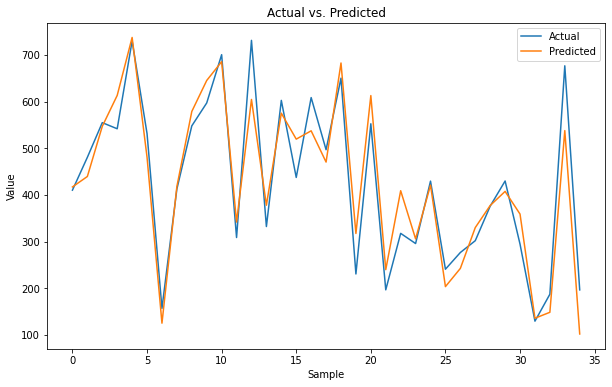

In [18]:
import matplotlib.pyplot as plt

def plot_comparison(y_pred, y_test):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Actual vs. Predicted')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage
# Replace y_pred and y_test with your actual data
# y_pred = [your predicted values]
# y_test = [your actual values]

plot_comparison(y_pred, y_test.values)
# plot_comparison()

### Saving and importing the model

In [19]:
# Save the model
model.save("my_model_2.h5")